In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf 
from tensorflow import keras
from keras.layers import Dense,Activation
from keras.optimizers import Adam
import seaborn as sns
import os 
import warnings 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates    #處理日期
import warnings 

warnings.filterwarnings("ignore")
data = pd.read_csv('./2018_2022/2018_2021_year_stock.csv')

date =data['日期']

# only can run once
for i in range(0,len(date)):
  date.iloc[i]=date.iloc[i].replace(date.iloc[i][0:3], str(int(date.iloc[i][0:3]) + 1911))
print('-'*20)


date=pd.to_datetime(date,format='%Y/%m/%d' ) 
data['日期'] = pd.to_datetime(data['日期'])

# print(data.info())



--------------------


** 二層前饋神經網路模型**


- to_numpy:from dataframe to array
- reshape(-1,1): from 1D array to 2D array

In [2]:
close_data_ = data['收盤價']
dataset=close_data_.to_numpy().reshape(-1,1)
print("-"*20)
training = int(np.ceil(len(dataset) * .95))
# print("traning:",training) #884


# 正規化數值
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

# 將資料擴充為二維2D，資料scaled_data的前884個資料
train_data = scaled_data[0:int(training),:]

# 創建自己的dataset
# prepare feature and labels
x_train = []
y_train = []
# labels
# labels的範圍是從60到884，總共824天資料範圍
# X_train 是0~60,1~61,2~62....,824~884
for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i,0])
  y_train.append(train_data[i,0])

x_train,y_train = np.array(x_train),np.array(y_train)
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
print(x_train)

--------------------
[[[0.23196605]
  [0.2446959 ]
  [0.25176803]
  ...
  [0.28995757]
  [0.28995757]
  [0.30127298]]

 [[0.2446959 ]
  [0.25176803]
  [0.25388967]
  ...
  [0.28995757]
  [0.30127298]
  [0.29349364]]

 [[0.25176803]
  [0.25388967]
  [0.26308345]
  ...
  [0.30127298]
  [0.29349364]
  [0.29278642]]

 ...

 [[0.89886846]
  [0.86845827]
  [0.87411598]
  ...
  [0.7397454 ]
  [0.74328147]
  [0.74611033]]

 [[0.86845827]
  [0.87411598]
  [0.89250354]
  ...
  [0.74328147]
  [0.74611033]
  [0.74398868]]

 [[0.87411598]
  [0.89250354]
  [0.89462518]
  ...
  [0.74611033]
  [0.74398868]
  [0.74611033]]]




## use tensorflow to build LDTM model
創建model，他是sequential類型的網路模型
這個model不是變數，而是sequential 類別生成的物件。請把物件當作幾個變數和函數的集合。Keras透過在model中增加"層"的方式定義網路結構。
* LSTM
LSTM 接受的輸入是三個維度，在 input_shape 參數中，可以僅輸入每一個 Sample 的維度，即是 (time_step, input_dim)。此處為 (10, 20) 表示每一個 Sample 有 10 個時間單位，每一個時間單位都是 20 維度的向量。至於 batch_size，則是實際將 data 輸入至神經網路時再決定即可。
* Dense
這個model增加"全連結層Dense"作為(網路)中間層
Dense()的第一個參數的值32是神經元的數量。
<br>
 units 參數即是表示 Ct 與 ot 的維度，Ct 與 ot 的維度又會決定 ht 的維度，也就是 LSTM 最後輸出的維度。<br>

In [3]:
model = keras.models.Sequential()
model.add(keras.layers.LSTM(units=64,
                            return_sequences=True,
                            input_shape=(x_train.shape[1],1)))
model.add(keras.layers.LSTM(units=64,return_sequences=False,activation='relu'))
model.add(keras.layers.Dense(32))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1))
model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 64)            16896     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 52033 (203.25 KB)
Trainable params: 52033 (203.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### model.compile
* optimizier: 這是通過使用梯度下降來幫助優化成本函數的方法。
* loss:我們用來監控模型是否隨著訓練而改進的損失函數。

將adam資料傳給compile()，以設定訓練方法。
以均方誤差做為目標函數。<br>
#mse為跑回歸任務的其中一個loss function
#回歸任務沒有acc只有loss


### model.fit()
參數x_train和y_train用於指定訓練資料，


In [4]:
model.compile(optimizer="adam",loss='mean_squared_error')
history= model.fit(x_train,y_train,epochs=10)

Epoch 1/10
26/26 [==============================] - 7s 37ms/step - loss: 0.0579
Epoch 2/10
26/26 [==============================] - 1s 35ms/step - loss: 0.0147
Epoch 3/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0126
Epoch 4/10
26/26 [==============================] - 1s 34ms/step - loss: 0.0118
Epoch 5/10
26/26 [==============================] - 1s 35ms/step - loss: 0.0113
Epoch 6/10
26/26 [==============================] - 1s 43ms/step - loss: 0.0102
Epoch 7/10
26/26 [==============================] - 1s 41ms/step - loss: 0.0106
Epoch 8/10
26/26 [==============================] - 1s 37ms/step - loss: 0.0103
Epoch 9/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0090
Epoch 10/10
26/26 [==============================] - 1s 38ms/step - loss: 0.0103


為了進行預測，我們需要測試數據，因此我們首先創建測試數據，然後進行模型預測。
- mse: mean square error 平均平方誤差
- rmse: root mean square error 均方根誤差
- x_test is target

In [5]:
test_data = scaled_data[training-60:,:]
x_test = []
y_test = dataset[training:,:]
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])

x_test = np.array(x_test)
x_test0 = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

# predict the testing data

predictions = model.predict(x_test0)
# print(predictions)
predictions = scaler.inverse_transform(predictions)

mse = np.mean(((predictions - x_test) ** 2))
# print("MSE",mse)
# print("RMSE",np.sqrt(mse))

def rmse(predictions,targets):
    #valueError: operands could not be broadcast together with shapes (46,1) (46,60,1)
    return np.sqrt(((predictions - targets) ** 2 ).mean())
rmse_val = rmse(predictions,x_test)
# print("rms error is: " + str(rmse_val))



2/2 [==============================] - 1s 13ms/step


我們已經預測了測試數據，讓我們可視化最終結果。

0      25.13
1      25.31
2      25.41
3      25.44
4      25.57
       ...  
879    32.36
880    32.40
881    32.37
882    32.40
883    30.84
Name: 收盤價, Length: 884, dtype: float64 884    31.964003
885    31.809849
886    31.644556
887    31.489429
888    31.368307
889    31.288206
890    31.236933
891    31.226196
892    31.248055
893    31.295992
894    31.390242
895    31.502949
896    31.619680
897    31.717133
898    31.800440
899    31.886063
900    31.978222
901    32.076588
902    32.192081
903    32.305634
904    32.410553
905    32.480045
906    32.521984
907    32.546288
908    32.534348
909    32.491440
910    32.453239
911    32.416603
912    32.397148
913    32.404938
914    32.441460
915    32.504505
916    32.590260
917    32.682632
918    32.775494
919    32.833248
920    32.873432
921    32.930248
922    32.989956
923    33.046013
924    33.092163
925    33.124420
926    33.148846
927    33.162365
928    33.175022
929    33.199429
Name: predictions, dtype: float32


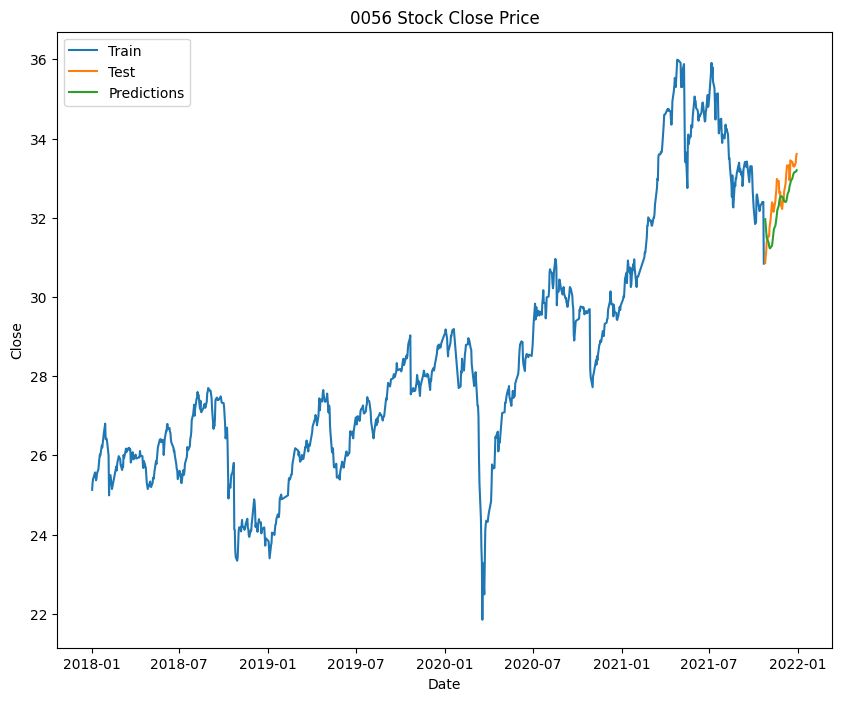

In [6]:
train = data[:training]
test = data[training:]

#train
date = train['日期']
close = train['收盤價']
test['predictions']= predictions
print(close,test['predictions'])
#test
date_ = test['日期']
close_ = test[['收盤價',"predictions"]]
plt.figure(figsize=(10,8))
plt.plot(date,close)
plt.plot(date_,close_)
plt.title("0056 Stock Close Price")
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend(['Train','Test','Predictions'])